# TrenchRipper Master Notebook

#### Imports

In [1]:
import trenchripper as tr

from ipywidgets import interact, interactive, fixed, interact_manual, FloatSlider, IntSlider, Dropdown, IntText, SelectMultiple, IntRangeSlider
import ipywidgets as widgets
import matplotlib
import warnings
import copy

matplotlib.rcParams['figure.figsize'] = [20, 10]
warnings.filterwarnings(action='once')

/home/de64/anaconda3/envs/mothermachine/lib/python3.6/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)


#### Specify Paths

Begin by defining the directory in which all processing will be done, as well as the initial nd2 file we will be processing.

In [2]:
headpath = "/n/scratch2/de64/2019-06-18_DE85_training_data"
nd2file = "/n/scratch2/de64/2019-06-18_DE85_training_data/bde17_gotime.nd2"

#### Transfer files into the scratch folder

In [ ]:
sourcedir = "/n/files/SysBio/PAULSSON\ LAB/Daniel/Image_Data/Bacillus_Project/2019-06-18_DE85_training_data"
targetdir = "/n/scratch2/de64/2019-06-18_DE85_training_data"
tr.cluster.transferjob(sourcedir,targetdir)

### Extract to hdf5 files

#### Start Dask Workers

In [2]:
dask_controller = tr.cluster.dask_controller(walltime='04:00:00',local=False,n_workers=40,memory='4GB')
dask_controller.startdask()
dask_controller.daskcluster.start_workers()

/home/de64/anaconda3/envs/mothermachine/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


In [3]:
dask_controller.displaydashboard()

#### Perform Extraction

In [10]:
hdf5_extractor = tr.ndextract.hdf5_fov_extractor(nd2file,headpath)

/home/de64/anaconda3/envs/mothermachine/lib/python3.6/site-packages/nd2reader/common_raw_metadata.py:94: RuntimeWarning: Reported average frame interval (587498.1 ms) doesn't match the set interval (600000.0 ms). Using the average now.
  warnings.warn(message % (avg_interval, interval), RuntimeWarning)


In [12]:
hdf5_extractor.writemetadata()
fov_list = hdf5_extractor.exp_metadata['fields_of_view']
dask_controller.mapfovs(hdf5_extractor.extract_fov,fov_list)

#### Shutdown Dask

In [5]:
dask_controller.shutdown()

## Kymographs

### Test Parameters

#### Initialize the interactive kymograph class

As a first step, initialize the `tr.interactive.kymograph_interactive` class that will be handling all steps of generating a kymograph. 

You will need to specify the following `args` and `kwargs` (in order):


**Args**

**input_file_prefix (string)** : File prefix for all input hdf5 files of the form "\[input_file_prefix\]\[number\].hdf5" This should be the default output format for the hdf5 export code, but you will need to rename files if taking input files from a different source.

**all_channels (list)** : list of strings corresponding to the different image channels available in the input hdf5 file, with the channel used for segmenting trenches in the first position. NOTE: these names must match those of the input hdf5 file datasets.

**fov_list (list)** : List of ints corresponding to the fovs that you wish to make kymographs of.

**Kwargs**

**t_subsample_step (int)** : Step size to be used for subsampling input files in time, recommend that subsampling results in between 5 and 20 timepoints for quick processing.

**t_range (tuple of ints)** : Range size to be used for subsampling input files in time.

The last line will perform import and subsampling of the input hdf5 image files.

In [17]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
interactive_kymograph = tr.interactive.kymograph_interactive(headpath)
channels,shape,all_fov_list,timepoints_len = interactive_kymograph.get_image_params(0)

In [18]:
interact(interactive_kymograph.view_image,fov_idx=IntText(value=0,description='FOV number:',disabled=False),\
         t=IntSlider(value=0, min=0, max=timepoints_len-1, step=1,continuous_update=False),
        channel=Dropdown(options=channels,value=channels[0],description='Channel:',disabled=False));

interactive(children=(IntText(value=0, description='FOV number:'), IntSlider(value=0, continuous_update=False,…

In [19]:
import_hdf5 = interactive(interactive_kymograph.import_hdf5_files, {"manual":True},all_channels=fixed(channels),seg_channel=Dropdown(options=channels,value=channels[0]),\
                          fov_list=SelectMultiple(options=all_fov_list),t_range=IntRangeSlider(value=[0, timepoints_len-1],min=0,max=timepoints_len-1,step=1,disabled=False,continuous_update=False),\
                          t_subsample_step=IntSlider(value=10, min=0, max=200, step=10));
display(import_hdf5)

interactive(children=(Dropdown(description='seg_channel', options=('channel_GFP', 'channel_Phase'), value='cha…

In [20]:
imported_array_list = copy.copy(import_hdf5.result)

#### Tune "trench-row" detection hyperparameters

The kymograph code begins by detecting the positions of trench rows in the image as follows:

1. Reducing each 2D image to a 1D signal along the y-axis by computing the qth percentile of the data along the x-axis
2. Smooth this signal using a median kernel
3. Use a [triangle threshold](https://imagej.net/Auto_Threshold#Triangle) to determine the trench row poisitons

This method uses the following `kwargs`, which you can tune here:

**y_percentile (int)** : Percentile to use for step 1.

**smoothing_kernel_y_dim_0 (int)** : Median kernel size to use for step 2.

**triangle_nbins (int)** : Number of bins to use in the triangle method histogram.

**triangle_scaling (float)** : Scaling factor to apply to the threshold determined by the triangle method.


Running the following widget will display the smoothed 1-D signal for each of your timepoints. In addition, the threshold value for each fov will be displayed as a red line.

In [21]:
matplotlib.rcParams['figure.figsize'] = [20, 10]

row_detection = interactive(interactive_kymograph.preview_y_precentiles, {"manual":True},imported_array_list=fixed(imported_array_list),y_percentile=IntSlider(value=100, min=0, max=100, step=1),\
         smoothing_kernel_y_dim_0=IntSlider(value=17, min=1, max=20, step=1),triangle_nbins=IntSlider(value=50, min=10, max=200, step=10),\
                triangle_scaling=FloatSlider(value=3.5, min=0., max=4., step=0.05));
display(row_detection)

interactive(children=(IntSlider(value=100, description='y_percentile'), IntSlider(value=17, description='smoot…

#### Generate "trench-row" detection output

After determining your desired hyperparameters, set them in the next cell and run it to produce output for later steps. **Note: The thresholding parameters do not need to be specified at this point.**

In [23]:
y_percentiles_smoothed_list = copy.copy(row_detection.result)

#### Tune "trench-row" cropping hyperparameters

Next, we will use the detected rows to perform cropping of the input image in the y-dimension:

1. Determine edges of trench rows based on threshold mask.
2. Filter out rows that are too small.
3. Perform cropping using the "end" of the row as reference (the end referring to the part of the trench farthest from the feeding channel).

This method uses the following `kwargs`, which you can tune here:

**triangle_nbins (int)** : Number of bins to use in the triangle method histogram.

**triangle_scaling (float)** : Scaling factor to apply to the threshold determined by the triangle method.

**y_min_edge_dist (int)** : Minimum row length necessary for detection.

**padding_y (int)** : Padding to be used when cropping in the y-dimension.

**trench_len_y (int)** : Length from the end of the tenches to be used when cropping in the y-dimension.

**top_orientation (int)** : The orientation of the top-most row where 0 corresponds to a trench with a downward-oriented trench opening and 1 corresponds to a trench with an upward-oriented trench opening.

**vertical_spacing (float)** : Parameter for setting the distance of plots being viewed.

Running the following widget will display y-cropped images for each fov and timepoint.

In [24]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
y_cropping = interactive(interactive_kymograph.preview_y_crop,{"manual":True},y_percentiles_smoothed_list=fixed(y_percentiles_smoothed_list),\
                imported_array_list=fixed(imported_array_list),\
                triangle_nbins=IntSlider(value=50, min=10, max=200, step=10),\
                triangle_scaling=FloatSlider(value=1.05, min=0., max=4., step=0.05),\
                y_min_edge_dist=IntSlider(value=50, min=10, max=200, step=10),\
                padding_y=IntSlider(value=20, min=0, max=100, step=1),\
                trench_len_y=IntSlider(value=270, min=0, max=1000, step=10),
               vertical_spacing=FloatSlider(value=0.9, min=0., max=2., step=0.01),\
                expected_num_rows=IntText(value=2,description='Number of Rows:',disabled=False),\
               orientation_detection=Dropdown(options=[0, 1, 'phase'],value=0,description='Orientation:',disabled=False),
                orientation_on_fail=Dropdown(options=[None,0, 1],value=0,description='Orientation when < expected rows:',disabled=False))
display(y_cropping)

interactive(children=(IntSlider(value=50, description='triangle_nbins', max=200, min=10, step=10), FloatSlider…

#### Generate "trench-row" cropping output

After determining your desired hyperparameters, set them in the next cell and run it to produce output for later steps.

In [25]:
cropped_in_y_list = copy.copy(y_cropping.result)

#### Tune trench detection hyperparameters

Next, we will detect the positions of trenchs in the y-cropped images as follows:

1. Reducing each 2D image to a 1D signal along the x-axis by computing the qth percentile of the data along the y-axis.
2. Determine the signal background by smooth this signal using a large median kernel.
3. Subtract the background signal.
4. Smooth the resultant signal using a median kernel.
5. Use a [otsu threhsold](https://imagej.net/Auto_Threshold#Otsu) to determine the trench midpoint poisitons.

This method uses the following `kwargs`, which you can tune here:

**x_percentile (int)** : Percentile to use for step 1.

**background_kernel_x (int)** : Median kernel size to use for step 2.

**smoothing_kernel_x (int)** : Median kernel size to use for step 4.

**otsu_nbins (int)** : Number of bins to use in the Otsu's method histogram.

**otsu_scaling (float)** : Scaling factor to apply to the threshold determined by Otsu's method.

**vertical_spacing (float)** : Parameter for setting the distance of plots being viewed.

Running the following widget will display the smoothed 1-D signal for each of your timepoints. In addition, the threshold value for each fov will be displayed as a red line.

In [26]:
trench_detection = interactive(interactive_kymograph.preview_x_percentiles, {"manual":True}, cropped_in_y_list=fixed(cropped_in_y_list),t=IntSlider(value=0, min=0, max=cropped_in_y_list[0].shape[4]-1, step=1),\
                x_percentile=IntSlider(value=85, min=50, max=100, step=1),background_kernel_x=IntSlider(value=21, min=1, max=601, step=20), smoothing_kernel_x=IntSlider(value=9, min=1, max=31, step=2),\
               otsu_nbins=IntSlider(value=50, min=10, max=200, step=10),otsu_scaling=FloatSlider(value=0.25, min=0., max=2., step=0.01),\
               vertical_spacing=FloatSlider(value=0.9, min=0., max=2., step=0.01));
display(trench_detection)

interactive(children=(IntSlider(value=0, description='t', max=4), IntSlider(value=85, description='x_percentil…

#### Generate trench detection output

After determining your desired hyperparameters, set them in the next cell and run it to produce output for later steps. **Note: The thresholding parameters do not need to be specified at this point.**

In [27]:
smoothed_x_percentiles_list = trench_detection.result

#### Check midpoint drift

Next, we will perform x-dimension drift correction of our detected midpoints as follows:

1. Begin at t=1
2. For $m \in \{midpoints(t)\}$ assign $n \in \{midpoints(t-1)\}$ to m if n is the closest midpoint to m at time $t-1$,
points that are not the closest midpoint to any midpoints in m will not be mapped.
3. Compute the translation of each midpoint at time.
4. Take the average of this value as the x-dimension drift from time t-1 to t.

This method uses the following `kwargs`, which you can tune here:

**otsu_nbins (int)** : Number of bins to use in the Otsu's method histogram.

**otsu_scaling (float)** : Scaling factor to apply to the threshold determined by Otsu's method.

**vertical_spacing (float)** : Parameter for setting the distance of plots being viewed.

Running the following widget will display the detected midpoints for each of your timepoints. If there is too much sparsity, or discontinuity, your drift correction will not be accurate.

In [28]:
midpoint_drift = interactive(interactive_kymograph.preview_midpoints,{"manual":True},smoothed_x_percentiles_list=fixed(smoothed_x_percentiles_list),\
                otsu_nbins=IntSlider(value=50, min=10, max=200, step=10),
                otsu_scaling=FloatSlider(value=0.25, min=0., max=2., step=0.01),\
               vertical_spacing=FloatSlider(value=0.8, min=0., max=2., step=0.01));
display(midpoint_drift)

interactive(children=(IntSlider(value=50, description='otsu_nbins', max=200, min=10, step=10), FloatSlider(val…

#### Generate midpoint drift output

After determining your desired hyperparameters, set them in the next cell and run it to produce output for later steps.

In [29]:
all_midpoints_list,x_drift_list = midpoint_drift.result

In [30]:
corrected_midpoints = interactive(interactive_kymograph.preview_corrected_midpoints,{"manual":True},all_midpoints_list=fixed(all_midpoints_list),\
                                  x_drift_list = fixed(x_drift_list),trench_width_x=IntSlider(value=30, min=10, max=50, step=1),\
                                  trench_present_thr=FloatSlider(value=0., min=0., max=1., step=0.05),\
                                  vertical_spacing=FloatSlider(value=0.8, min=0., max=2., step=0.01));
display(corrected_midpoints)

interactive(children=(IntSlider(value=30, description='trench_width_x', max=50, min=10), FloatSlider(value=0.0…

#### Tune trench cropping hyperparameters

Trench cropping simply uses the drift-corrected midpoints as a reference and crops out some fixed length around them to produce an output kymograph

This method uses the following `kwargs`, which you can tune here:

**trench_width_x (int)** : Trench width to use for cropping.

**vertical_spacing (float)** : Parameter for setting the distance of plots being viewed.

Running the following widget will display a random kymograph for each row in each fov.

In [31]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
interact_manual(interactive_kymograph.preview_kymographs,cropped_in_y_list=fixed(cropped_in_y_list),all_midpoints_list=fixed(all_midpoints_list),\
                x_drift_list=fixed(x_drift_list),trench_width_x=IntSlider(value=30, min=10, max=50, step=1),\
                trench_present_thr=FloatSlider(value=0., min=0., max=1., step=0.05),\
               vertical_spacing=FloatSlider(value=0.8, min=0., max=2., step=0.01))

interactive(children=(IntSlider(value=30, description='trench_width_x', max=50, min=10), FloatSlider(value=0.0…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

#### Export and save hyperparameters

In [32]:
interactive_kymograph.process_results()

Y Percentile 99
Y Smoothing Kernel 17
Triangle Trheshold Bins 50
Triangle Threshold Scaling 3.5
Minimum Trench Length 50
Y Padding 30
Trench Length 300
Orientation Detection Method 1
Expected Number of Rows (Manual Orientation Detection) 1
Top Orientation when Row Drifts Out (Manual Orientation Detection) 1
X Percentile 95
X Background Kernel 21
X Smoothing Kernel 9
Otsu Trheshold Bins 50
Otsu Threshold Scaling 0.25
Trench Width 22
Trench Presence Threshold 0.6
All Channels ['channel_GFP', 'channel_Phase']
Time Range (0, 49)


In [33]:
interactive_kymograph.write_param_file()

### Generate Kymograph

#### Start Dask Workers

In [34]:
dask_controller = tr.cluster.dask_controller(walltime='04:00:00',local=False,n_workers=20,memory='4GB')
dask_controller.startdask()
dask_controller.daskcluster.start_workers()

/home/de64/anaconda3/envs/mothermachine/lib/python3.6/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "
/home/de64/anaconda3/envs/mothermachine/lib/python3.6/site-packages/distributed/bokeh/core.py:74: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn("\n" + msg)
/home/de64/anaconda3/envs/mothermachine/lib/python3.6/site-packages/distributed/bokeh/core.py:77: ResourceWarning: unclosed <socket.socket fd=91, family=AddressFamily.AF_INET, type=2049, proto=6, laddr=('0.0.0.0', 0)>
  raise


In [35]:
dask_controller.displaydashboard()

In [36]:
kymo = tr.kymograph.kychunker(headpath=headpath,paramfile=True)

In [37]:
kymo.dask_full_kymograph(dask_controller)

/home/de64/TrenchRipper/trenchripper/utils.py:295: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


#### Check kymograph statistics

In [38]:
kymo.kymo_report()

fovs processed: 41/50
lanes processed: 41
trenches processed: 1605
lanes/fov: 1.0
trenches/fov: 39.146341463414636
failed fovs: [35, 37, 11, 12, 45, 47, 48, 49, 31]


#### Shutdown Dask

In [39]:
dask_controller.shutdown()

## Segmentation

### Test Parameters

#### Initialize the interactive segmentation class

As a first step, initialize the `tr.interactive.fluo_segmentation_interactive` class that will be handling all steps of generating a segmentation. 

You will need to specify the following `args` (in order):


**Args**

**headpath (string)** : Top level path being used for processing (same as the rest of the mother machine pipeline.)

In [3]:
matplotlib.rcParams['figure.figsize'] = [20, 10]
interactive_segmentation = tr.interactive.fluo_segmentation_interactive(headpath)

/home/de64/anaconda3/envs/mothermachine/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
/home/de64/TrenchRipper/trenchripper/utils.py:295: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  df.metadata = store.get_storer(key).attrs.metadata


#### Choose channel to segment on

In [4]:
choose_channel = interactive(interactive_segmentation.choose_seg_channel, {"manual":True},seg_channel=Dropdown(options=interactive_segmentation.all_channels,\
                                                                                              value=interactive_segmentation.all_channels[0]));
display(choose_channel)

interactive(children=(Dropdown(description='seg_channel', options=('channel_Phase', 'channel_GFP'), value='cha…

#### Import data

Fill in 

You will need to tune the following `args` and `kwargs` (in order):

**fov_idx (int)** :

**n_trenches (int)** :

**t_range (tuple)** :

**t_subsample_step (int)** :

In [5]:
kymo_arr_int = interactive(interactive_segmentation.import_array, {"manual":True},fov_idx=IntText(value=0,description='FOV number:',disabled=False),\
                       n_trenches=IntText(value=1,description='Number of trenches:',disabled=False),\
                       t_range=IntRangeSlider(value=[interactive_segmentation.t_range[0],interactive_segmentation.t_range[1]-1],\
                        description='Time Range:',min=interactive_segmentation.t_range[0],max=interactive_segmentation.t_range[1]-1,step=1,disabled=False),\
                       t_subsample_step=IntSlider(value=1,description='Time Subsampling Step:', min=1, max=20, step=1),\
                       fig_size_y=IntSlider(value=9, description='Figure Size (Y Dimension):' , min=1, max=30, step=1),\
                       fig_size_x=IntSlider(value=6, description='Figure Size (X Dimension):', min=1, max=30, step=1));
display(kymo_arr_int)

interactive(children=(IntText(value=0, description='FOV number:'), IntText(value=1, description='Number of tre…

In [6]:
kymo_arr = copy.copy(kymo_arr_int.result)

#### Scale data

Fill in 

You will need to tune the following `args` and `kwargs` (in order):

**scale (bool)** : Whether to scale the kymograph in time.

**scaling_percentile (int)** : Whole image intensity percentile to use to determine scaling constant. 

In [7]:
scaled_list_int = interactive(interactive_segmentation.plot_scaled, {"manual":True},kymo_arr=fixed(kymo_arr),\
                          scale=Dropdown(options=[True,False],value=True,description='Scale Fluorescence?',disabled=False),\
                          scaling_percentile=IntSlider(value=90,description='Scaling Percentile:',min=0,max=100,step=1,disabled=False));
display(scaled_list_int)

interactive(children=(Dropdown(description='Scale Fluorescence?', options=(True, False), value=True), IntSlide…

In [8]:
scaled_list = copy.copy(scaled_list_int.result)

#### Apply Gaussian Filter

Fill in 

You will need to tune the following `args` and `kwargs` (in order):

**smooth_sigma (float)** : Standard deviation of gaussian kernel.

In [9]:
proc_list_int = interactive(interactive_segmentation.plot_processed, {"manual":True},scaled_list=fixed(scaled_list),\
                          smooth_sigma=FloatSlider(value=0.75,description='Gaussian Kernel Sigma:',min=0.,max=3.,step=0.25,disabled=False));
display(proc_list_int)

interactive(children=(FloatSlider(value=0.75, description='Gaussian Kernel Sigma:', max=3.0, step=0.25), Butto…

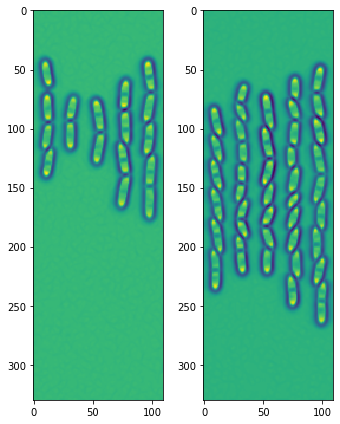

In [10]:
proc_list = copy.copy(proc_list_int.result)
eigval_list = interactive_segmentation.plot_eigval(proc_list)

#### Determine Cell Mask Envelope

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**cell_mask_method (str)** : Thresholding method, can be a local or global Otsu threshold.

**cell_otsu_scaling (float)** : Scaling factor applied to determined threshold.

**local_otsu_r (int)** : Radius of thresholding kernel used in the local otsu thresholding.

In [11]:
cell_mask_list_int = interactive(interactive_segmentation.plot_cell_mask, {"manual":True},proc_list=fixed(proc_list),\
                          cell_mask_method=Dropdown(options=['local','global'],value='local',description='Cell Mask Thresholding Method:',disabled=False),\
                          global_otsu_scaling=FloatSlider(value=0.95,description='Global Threshold Scaling:',min=0.,max=2.,step=0.01,disabled=False),\
                          cell_otsu_scaling=FloatSlider(value=0.95,description='Cell Threshold Scaling:',min=0.,max=2.,step=0.01,disabled=False),\
                          local_otsu_r=IntSlider(value=15,description='Local Otsu Radius:',min=0,max=30,step=1,disabled=False));
display(cell_mask_list_int)

interactive(children=(FloatSlider(value=0.95, description='Global Threshold Scaling:', max=2.0, step=0.01), Dr…

In [12]:
cell_mask_list = copy.copy(cell_mask_list_int.result)

#### Display Edge Mask at Threshold Value

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**edge_threshold_scaling (float)** : Scaling factor applied to determined threshold.

In [13]:
composite_mask_list_int = interactive(interactive_segmentation.plot_threshold_result, {"manual":True},eigval_list=fixed(eigval_list),cell_mask_list=fixed(cell_mask_list),\
                          edge_threshold_scaling=FloatSlider(value=1.,description='Edge Threshold Scaling',min=0.,max=2.,step=0.01,disabled=False),\
                          min_obj_size=IntSlider(value=30,description='Minimum Object Size:',min=0,max=100,step=2,disabled=False));
display(composite_mask_list_int)

interactive(children=(FloatSlider(value=1.0, description='Edge Threshold Scaling', max=2.0, step=0.01), IntSli…

#### Threshold Sampling and Convexity Calculation

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**edge_threshold_scaling (float)** : Scaling factor applied to determined threshold.

**threshold_step_perc (float)** : Threshold step size to be used for trying multiple thresholds.

**threshold_perc_num_steps (int)** : Number of steps to use when generating multiple thresholds.

In [14]:
conv_scores_list_int = interactive(interactive_segmentation.plot_scores, {"manual":True},eigval_list=fixed(eigval_list),cell_mask_list=fixed(cell_mask_list),\
                          edge_threshold_scaling=FloatSlider(value=0.9,description='Edge Threshold Scaling',min=0.,max=2.,step=0.01,disabled=False),\
                          threshold_step_perc=FloatSlider(value=0.05,description='Threshold Step Percent',min=0.,max=0.5,step=0.01,disabled=False),\
                          threshold_perc_num_steps=IntSlider(value=2,description='Number of Threshold Steps',min=0,max=5,step=1,disabled=False),\
                          min_obj_size=IntSlider(value=30,description='Minimum Object Size:',min=0,max=100,step=2,disabled=False));
display(conv_scores_list_int)

interactive(children=(FloatSlider(value=0.9, description='Edge Threshold Scaling', max=2.0, step=0.01), FloatS…

In [15]:
conv_scores_list = copy.copy(conv_scores_list_int.result)

#### Convexity Thresholding

Fill in.

You will need to tune the following `args` and `kwargs` (in order):

**convex_threshold (float)** : Threshold to be used for convexity thresholding.

In [16]:
final_mask_list_int = interactive(interactive_segmentation.plot_final_mask, {"manual":True},conv_scores_list=fixed(conv_scores_list),\
                          convex_threshold=FloatSlider(value=0.75,description='Convexity Threshold:',min=0.,max=1.,step=0.01,disabled=False));
display(final_mask_list_int)

interactive(children=(FloatSlider(value=0.75, description='Convexity Threshold:', max=1.0, step=0.01), Button(…

In [18]:
interactive_segmentation.process_results()

Scale Fluorescence? False
Scaling Percentile: 90
Gaussian Kernel Sigma: 1.25
Cell Mask Thresholding Method: local
Global Threshold Scaling: 1.25
Cell Threshold Scaling: 1.05
Local Otsu Radius: 15
Edge Threshold Scaling: 0.9
Threshold Step Percent: 0.05
Number of Threshold Steps: 2
Minimum Object Size: 30
Segmentation Channel: channel_GFP
Convexity Threshold: 0.75


In [19]:
interactive_segmentation.write_param_file()

### Generate Segmentation

#### Start Dask Workers

In [3]:
dask_controller = tr.cluster.dask_controller(walltime='01:00:00',local=False,n_workers=40,memory='1GB')
dask_controller.startdask()
dask_controller.daskcluster.start_workers()

In [6]:
dask_controller.displaydashboard()

In [7]:
segment = tr.segment.fluo_segmentation_cluster(headpath,paramfile=True)

In [8]:
segment.dask_segment(dask_controller)

/home/de64/anaconda3/envs/mothermachine/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


## Other

#### Dask Utilities

In [39]:
dask_controller.shutdown()

In [17]:
dask_controller.retry_failed()

Worker tcp://10.120.16.117:43008 restart in Job 43139620. This can be due to memory issue.
Worker tcp://10.120.17.99:46159 restart in Job 43139597. This can be due to memory issue.
Worker tcp://10.120.17.99:47339 restart in Job 43139596. This can be due to memory issue.
Worker tcp://10.120.16.54:36220 restart in Job 43139615. This can be due to memory issue.
Worker tcp://10.120.17.112:51330 restart in Job 43139598. This can be due to memory issue.
Worker tcp://10.120.16.49:52635 restart in Job 43139590. This can be due to memory issue.
Worker tcp://10.120.17.129:42849 restart in Job 43139600. This can be due to memory issue.
Worker tcp://10.120.17.129:52698 restart in Job 43139601. This can be due to memory issue.
Worker tcp://10.120.17.120:34163 restart in Job 43139608. This can be due to memory issue.
Worker tcp://10.120.17.120:49615 restart in Job 43139609. This can be due to memory issue.
Worker tcp://10.120.16.135:51837 restart in Job 43139621. This can be due to memory issue.
Wor

In [25]:
dask_controller.daskclient.restart()

distributed.scheduler - INFO - Send lost future signal to clients
distributed.scheduler - INFO - Remove worker tcp://10.120.16.168:56574
distributed.core - INFO - Removing comms to tcp://10.120.16.168:56574
distributed.scheduler - INFO - Remove worker tcp://10.120.16.179:47654
distributed.core - INFO - Removing comms to tcp://10.120.16.179:47654
distributed.scheduler - INFO - Remove worker tcp://10.120.16.185:34174
distributed.core - INFO - Removing comms to tcp://10.120.16.185:34174
distributed.scheduler - INFO - Remove worker tcp://10.120.16.185:40188
distributed.core - INFO - Removing comms to tcp://10.120.16.185:40188
distributed.scheduler - INFO - Remove worker tcp://10.120.16.186:35178
distributed.core - INFO - Removing comms to tcp://10.120.16.186:35178
distributed.scheduler - INFO - Remove worker tcp://10.120.16.186:35857
distributed.core - INFO - Removing comms to tcp://10.120.16.186:35857
distributed.scheduler - INFO - Remove worker tcp://10.120.16.186:36989
distributed.core 

Client Scheduler: tcp://10.120.16.190:37840 Dashboard: http://10.120.16.190:40482/status,Cluster Workers: 41 Cores: 41 Memory: 164.00 GB


In [13]:
dask_controller.retry_processing()